- Extracting Data from dummyJSON API
- Loading raw data to BigQuery
- Executing a query to perform the analysis
  
DummyJSON provides a dummy/fake JSON data to use as placeholder in development or in prototype testing: https://dummyjson.com/
<div>
&nbsp
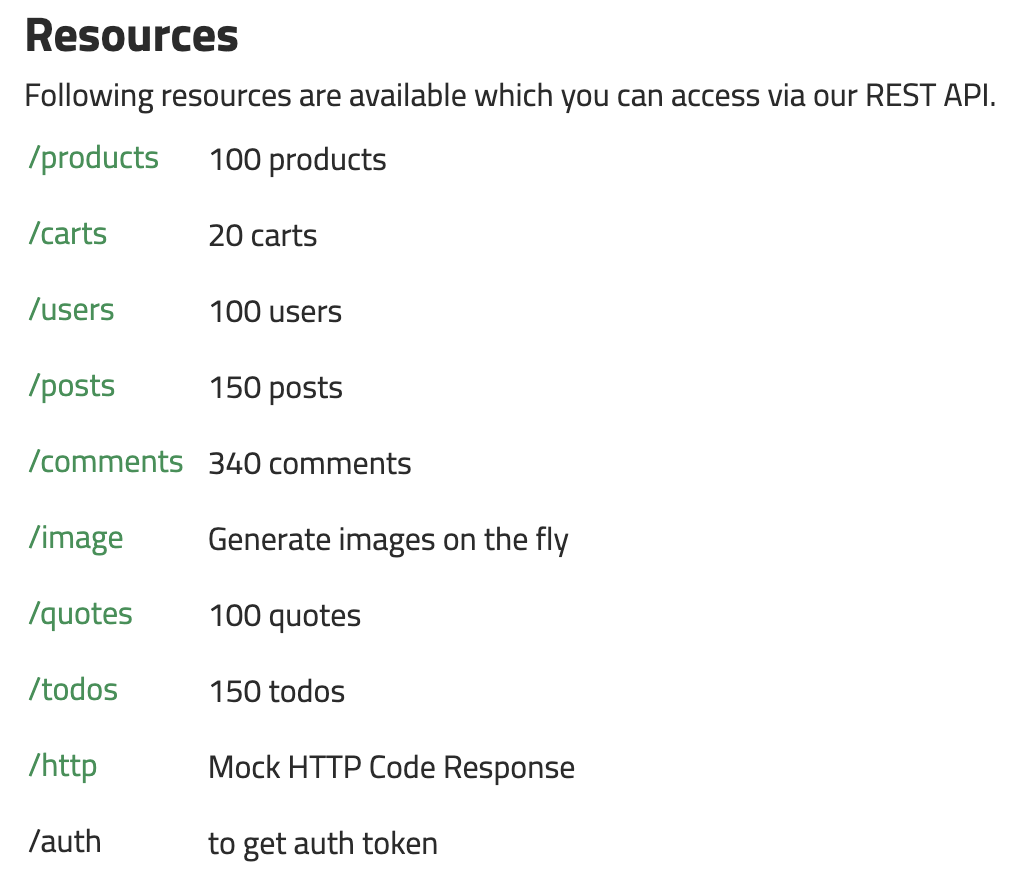
</div>

In [3]:
import requests

ENDPOINT = "https://dummyjson.com/"

def make_api_call(resource):
    ENDPOINT = "https://dummyjson.com/"
    response = requests.get(f"{ENDPOINT}{resource}")
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(response.text)

make_api_call("carts")

{'carts': [{'id': 1,
   'products': [{'id': 59,
     'title': 'Spring and summershoes',
     'price': 20,
     'quantity': 3,
     'total': 60,
     'discountPercentage': 8.71,
     'discountedPrice': 55},
    {'id': 88,
     'title': 'TC Reusable Silicone Magic Washing Gloves',
     'price': 29,
     'quantity': 2,
     'total': 58,
     'discountPercentage': 3.19,
     'discountedPrice': 56},
    {'id': 18,
     'title': 'Oil Free Moisturizer 100ml',
     'price': 40,
     'quantity': 2,
     'total': 80,
     'discountPercentage': 13.1,
     'discountedPrice': 70},
    {'id': 95,
     'title': 'Wholesale cargo lashing Belt',
     'price': 930,
     'quantity': 1,
     'total': 930,
     'discountPercentage': 17.67,
     'discountedPrice': 766},
    {'id': 39,
     'title': 'Women Sweaters Wool',
     'price': 600,
     'quantity': 2,
     'total': 1200,
     'discountPercentage': 17.2,
     'discountedPrice': 994}],
   'total': 2328,
   'discountedTotal': 1941,
   'userId': 97,
   '

In [4]:
make_api_call("users")

{'users': [{'id': 1,
   'firstName': 'Terry',
   'lastName': 'Medhurst',
   'maidenName': 'Smitham',
   'age': 50,
   'gender': 'male',
   'email': 'atuny0@sohu.com',
   'phone': '+63 791 675 8914',
   'username': 'atuny0',
   'password': '9uQFF1Lh',
   'birthDate': '2000-12-25',
   'image': 'https://robohash.org/hicveldicta.png',
   'bloodGroup': 'A−',
   'height': 189,
   'weight': 75.4,
   'eyeColor': 'Green',
   'hair': {'color': 'Black', 'type': 'Strands'},
   'domain': 'slashdot.org',
   'ip': '117.29.86.254',
   'address': {'address': '1745 T Street Southeast',
    'city': 'Washington',
    'coordinates': {'lat': 38.867033, 'lng': -76.979235},
    'postalCode': '20020',
    'state': 'DC'},
   'macAddress': '13:69:BA:56:A3:74',
   'university': 'Capitol University',
   'bank': {'cardExpire': '06/22',
    'cardNumber': '50380955204220685',
    'cardType': 'maestro',
    'currency': 'Peso',
    'iban': 'NO17 0695 2754 967'},
   'company': {'address': {'address': '629 Debbie Drive',

In [12]:
def make_api_call(resource):
    
    ENDPOINT = "https://dummyjson.com/"
    results_picked = 0
    total_results = 100 #initialize
    all_data = []
    
    while results_picked < total_results:
        response = requests.get(f"{ENDPOINT}{resource}", params = {"skip": results_picked})
        if response.status_code == 200:
            data = response.json()
            rows = data.get(resource)
            all_data += rows #concatening the two lists
            total_results = data.get("total")
            results_picked += len(rows) 
        else:
            raise Exception(response.text)
    return all_data

users_data = make_api_call("users")
carts_data = make_api_call("carts")
print(len(users_data))

100


In [13]:
import json

def download_json(data, resource_name):
    file_path = f"{resource_name}.json"
    with open(file_path, "w") as file:
        file.write("\n".join([json.dumps(row) for row in data]))

download_json(carts_data, "carts")
download_json(users_data, "users")

In [15]:
#BigQuery client library
!pip install --upgrade google-cloud-bigquery

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


In [16]:
#Load to BigQuery
def load_file(resource, client):
    table_id = f"data-analysis-347920.medium.dummy_{resource}"

    job_config = bigquery.LoadJobConfig(
        source_format=bigquery.SourceFormat.NEWLINE_DELIMITED_JSON, 
        autodetect=True,
        write_disposition="write_truncate"
    )

    with open(f"{resource}.json", "rb") as source_file:
        job = client.load_table_from_file(source_file, table_id, job_config=job_config)

        job.result()  # Waits for the job to complete.

        table = client.get_table(table_id)  # Make an API request.
        print(
            "Loaded {} rows and {} columns to {}".format(
                table.num_rows, len(table.schema), table_id
            )
        )

client = bigquery.Client()
load_file("carts", client)
load_file("users", client)

SyntaxError: invalid syntax (399707694.py, line 1)

In [20]:
#Join on the BigQuery

SELECT 
  u.id AS user_id,
  u.firstName AS user_first_name, 
  u.lastName AS user_last_name,
  SUM(total) AS total_spent
FROM `data-analysis-347920.medium.dummy_users` u
LEFT JOIN  `data-analysis-347920.medium.dummy_carts` c
ON u.id= c.userId
GROUP BY u.id,user_first_name,user_last_name
ORDER BY total_spent DESC

IndentationError: unexpected indent (4057893055.py, line 4)

In [18]:
#Adding the following query for the ELT process:

query= """
SELECT 
  u.id AS user_id,
  u.firstName AS user_first_name, 
  u.lastName AS user_last_name,
  SUM(total) AS total_spent
FROM `data-analysis-347920.medium.dummy_users` u
LEFT JOIN  `data-analysis-347920.medium.dummy_carts` c
ON u.id= c.userId
GROUP BY u.id,user_first_name,user_last_name
"""

query_config= bigquery.QueryJobConfig(
    destination = "data-analysis-347920.medium.dummy_best_spenders", 
    write_disposition= "write_truncate"
    )
client.query(query, job_config= query_config)

SyntaxError: invalid syntax (1254104149.py, line 1)

Reference: https://towardsdatascience.com/how-to-build-an-elt-with-python-8f5d9d75a12e